In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.signal import find_peaks
import warnings

warnings.filterwarnings("ignore")


# Datas


In [68]:
# unkown sample datas
data_uk = pd.read_excel("radiation_datas.xlsx", sheet_name="unknown")
uk_channel = data_uk["u_channel"]
uk_counts = data_uk["u_counts"]

# cobalt-60 datas
data_co = pd.read_excel("radiation_datas.xlsx", sheet_name="cobalt")
co_channel = data_co["c_channel"]
co_counts = data_co["c_counts"]

# Barium-133 datas
data_ba = pd.read_excel("radiation_datas.xlsx", sheet_name="barium")
ba_channel = data_ba["b_channel"]
ba_counts = data_ba["b_counts"]


# Functions


In [80]:
var = 100/50
# interpolation function
def interpolate(x, y):
    f = interp1d(x, y, kind="cubic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# full width half maxima function
def FWHM(x_n, y_n):
    # create a spline
    spline = UnivariateSpline(x_n, y_n - np.max(y_n) / var, s=0)
    x1, x2 = spline.roots()  # find the roots
    return x1, x2


def FWHM_co(x_n, y_n):
    # create a spline
    spline = UnivariateSpline(x_n, y_n - np.max(y_n) / var, s=0)
    x1, x2, x3, x4 = spline.roots()  # find the roots
    return x1, x2, x3, x4

# funciton for polynomial fitting
def polfit(a, b, c):
    z = np.polyfit(a, b, c)
    f = np.poly1d(z)

    x = np.arange(a[0], a[len(a) - 1], 0.001)
    y = f(x)
    return x, y

# Interpolation


In [81]:
channel_interpolated_ba, counts_interpolated_ba = interpolate(ba_channel, ba_counts)
channel_interpolated_co, counts_interpolated_co = interpolate(co_channel, co_counts)
channel_interpolated_uk, counts_interpolated_uk = interpolate(uk_channel, uk_counts)

element_name = ["Barium-133", "Cobalt-60", "Unknown Source"]
channel_interpolated = [channel_interpolated_ba, channel_interpolated_co, channel_interpolated_uk]
counts_interpolated = [counts_interpolated_ba, counts_interpolated_co, counts_interpolated_uk]
channel_original = [ba_channel, co_channel, uk_channel]
counts_original = [ba_counts, co_counts, uk_counts]


# Calculations

## Finding the Full width at half maxima(FWHM)

From the above graph, I am considering the interpolated datas and then going to find the FWHM here


In [82]:
# plt.style.use("seaborn-poster")
# plt.figure(figsize=(15, 24))

del_V = []
vi = []
for i in range(len(element_name)):
    if element_name[i] != "Cobalt-60":
        r1, r2= FWHM(channel_interpolated[i], counts_interpolated[i])
        vi.append(r1)
        vi.append(r2)
        del_V.append(r2 - r1)
        if element_name[i] == "Unknown Sample":
            print(f"{element_name[i]}: \n\t V1 = {r1:.2f}, V2 = {r2:.2f}, del_V = {del_V[i+1]:.2f}")
        elif element_name[i] == "Barium-133":
            print(f"{element_name[i]}: \n\t V1 = {r1:.2f}, V2 = {r2:.2f}, del_V = {del_V[i]:.2f}")

    if element_name[i] == "Cobalt-60":
        r1, r2, r3, r4 = FWHM_co(channel_interpolated[i], counts_interpolated[i])
        vi.append(r1)
        vi.append(r2)
        vi.append(r3)
        vi.append(r4)
        del_V.append(r2 - r1)
        del_V.append(r4 - r3)
        print(
            f"{element_name[i]}: \n\t V1 = {r1:.2f}, V2 = {r2:.2f}, del_V = {del_V[i]:.2f} \n\t V3 = {r3:.2f}, V4 = {r4:.2f}, del_V = {del_V[i+1]:.2f}"
        )


Barium-133: 
	 V1 = 12.16, V2 = 13.97, del_V = 1.82
Cobalt-60: 
	 V1 = 40.93, V2 = 44.19, del_V = 3.26 
	 V3 = 47.21, V4 = 50.76, del_V = 3.55


## Peak determination


In [83]:
res_name = ["Barium-133", "Cobalt-60 lower peak", "Cobalt-60 upper peak"]

for i in range(3):
    peak_id_max = find_peaks(counts_interpolated[i], height=np.max(counts_interpolated[i]) - 5000)
    heights = peak_id_max[1]["peak_heights"]
    pos = channel_interpolated[i][peak_id_max[0]]
    print(f"{element_name[i]}: \n\t channel = {pos} and peak = {heights}")


peak_counts = [110920, 28887, 25867]
peak_channel = [13, 42, 49]
known_energy = [0.356, 1.173, 1.332]

Barium-133: 
	 channel = [13.05] and peak = [110919.8321568]
Cobalt-60: 
	 channel = [42.314 48.832] and peak = [28886.73655762 25866.93528931]
Unknown Source: 
	 channel = [23.949] and peak = [43029.88507938]


# Spectrums


## Barium-133


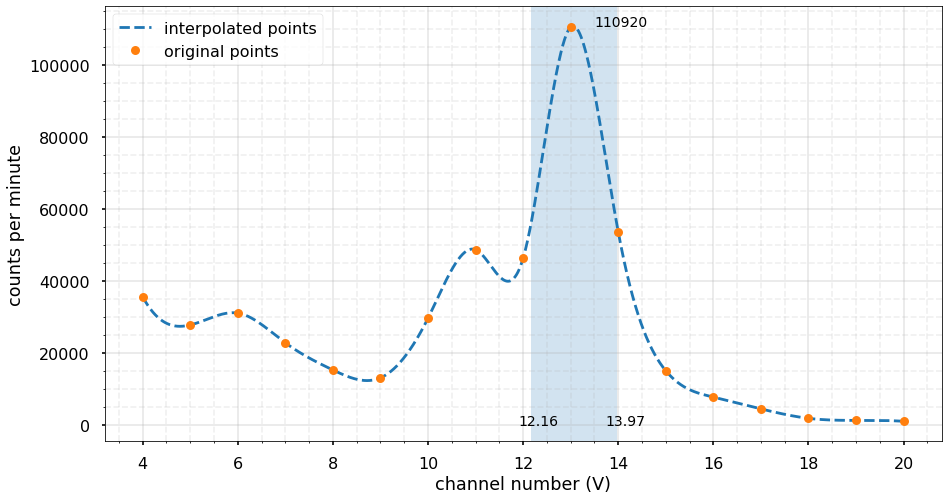

In [84]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))

plt.axvspan(vi[0], vi[1], alpha=0.2)
for i in range(2):
    plt.annotate(f"{vi[i]:.2f}", xy=(vi[i]-0.25, 0), fontsize=14)
plt.annotate(f"{peak_counts[0]}", xy=(peak_channel[0] + 0.5, peak_counts[0]), fontsize=14)

# plt.title(f"{element_name[0]} Spectrum")
plt.xlabel("channel number (V)")
plt.ylabel("counts per minute")
plt.plot(channel_interpolated_ba, counts_interpolated_ba, "--", label="interpolated points")
plt.plot(ba_channel, ba_counts, "o", markersize=9, label="original points")
plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")


## Cobalt-60


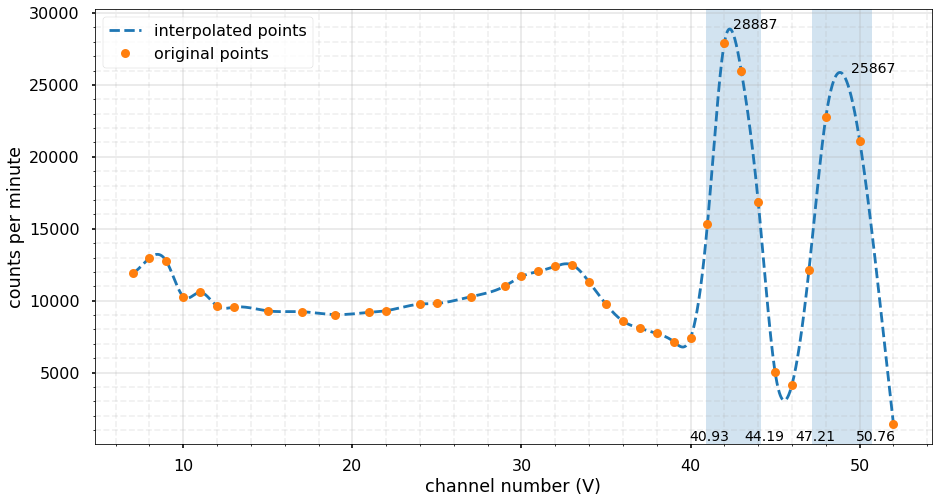

In [85]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))

plt.axvspan(vi[2], vi[3], alpha=0.2)
plt.axvspan(vi[4], vi[5], alpha=0.2)

for i in range(2, 6):
    plt.annotate(f"{vi[i]:.2f}", xy=(vi[i]-1, 300), fontsize=14)
for i in range(1,3):
    plt.annotate(f"{peak_counts[i]}", xy=(peak_channel[i] + 0.5, peak_counts[i]), fontsize=14)

# plt.title(f"{element_name[1]} Spectrum")
plt.xlabel("channel number (V)")
plt.ylabel("counts per minute")
plt.plot(channel_interpolated_co, counts_interpolated_co, "--", label="interpolated points")
plt.plot(co_channel, co_counts, "o", markersize=9, label="original points")
plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")

plt.show()


## Cesium-144


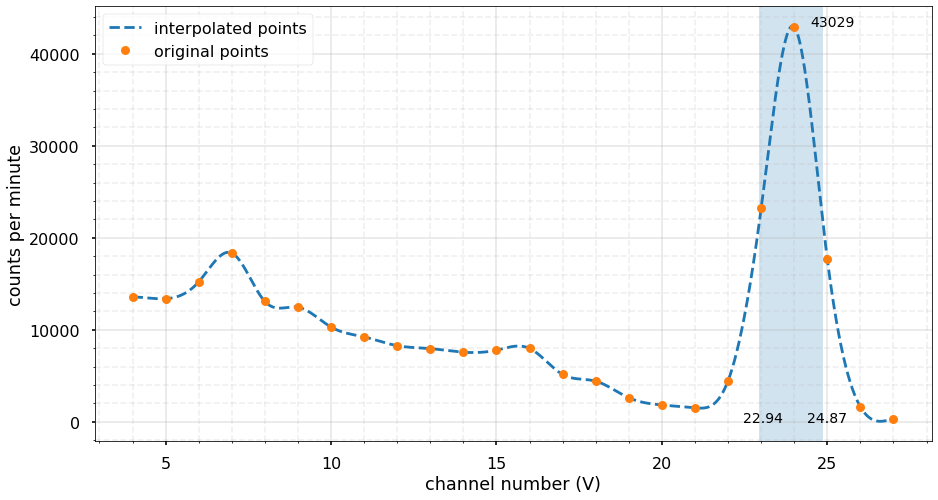

In [86]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))

plt.axvspan(vi[6], vi[7], alpha=0.2)
for i in range(6, 8):
    plt.annotate(f"{vi[i]:.2f}", xy=(vi[i]-0.5, 0), fontsize=14)
plt.annotate(f"43029", xy=(24 + 0.5, 43029), fontsize=14)

# plt.title(f"{element_name[2]} Spectrum")
plt.xlabel("channel number (V)")
plt.ylabel("counts per minute")
plt.plot(channel_interpolated_uk, counts_interpolated_uk, "--", label="interpolated points")
plt.plot(uk_channel, uk_counts, "o", markersize=9, label="original points")
plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")


## Unknown samples energy

The energy of the unknown sample is calculated from the calibaration curve


In [87]:
unknown_energy = np.interp(24, peak_channel, known_energy)
print(f"Energy of Unknown Sample from the calibaration curve = {unknown_energy:.3f} MeV")

peak_channel.append(24)
known_energy.append(unknown_energy)
res_name.append("Unknown Source")


Energy of Unknown Sample from the calibaration curve = 0.666 MeV


# Finding the Energy


## Calibaration Curve

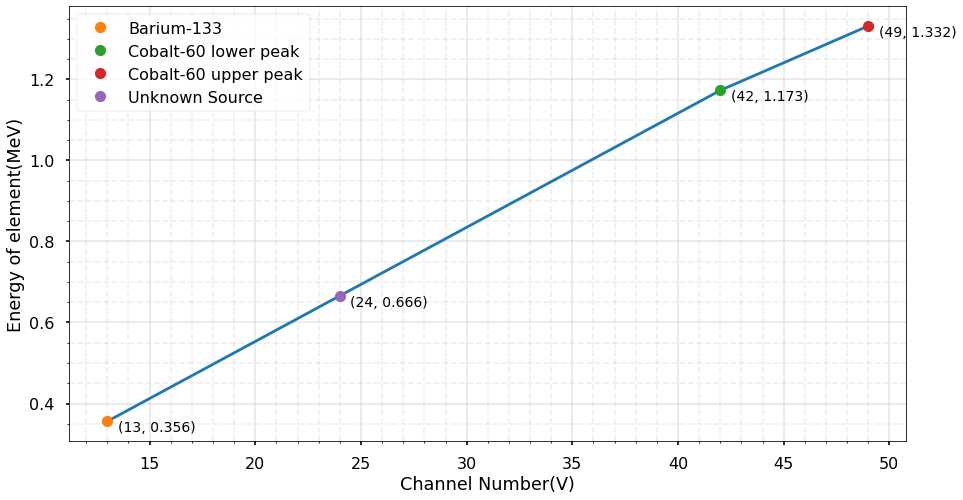

In [88]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
# plt.title(f"Calibaration curve")
plt.xlabel("Channel Number(V)")
plt.ylabel("Energy of element(MeV)")

plt.plot(np.sort(peak_channel), np.sort(known_energy))
for i in range(len(res_name)):
    plt.plot(peak_channel[i], known_energy[i], "o", label=res_name[i])
    plt.annotate(f"({peak_channel[i]}, {known_energy[i]:.3f})", xy=(peak_channel[i]+0.5,known_energy[i]-0.025), fontsize=14)
plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")
plt.show()


# Resolution Curve


In [89]:
# resolution
V = peak_channel
resolution = []

for i in range(len(res_name)):
    res = (del_V[i] / V[i]) * 100
    resolution.append(res)
    print(
        f"{res_name[i]}: \n\t resolution = {resolution[i]:.2f}%, del_V = {del_V[i]:.2f}, V = {V[i]}"
    )
sqrt_energy = 1 / np.sqrt(known_energy)
# for i in range(4):
#     print(f"{sqrt_energy[i]:0.2f}, {resolution[i]:.2f}")


sqe_int, res_int = polfit(np.sort(sqrt_energy), np.sort(resolution), 1)
# print(sqe_int,res_int)

Barium-133: 
	 resolution = 13.96%, del_V = 1.82, V = 13
Cobalt-60 lower peak: 
	 resolution = 7.77%, del_V = 3.26, V = 42
Cobalt-60 upper peak: 
	 resolution = 7.25%, del_V = 3.55, V = 49
Unknown Source: 
	 resolution = 8.06%, del_V = 1.93, V = 24


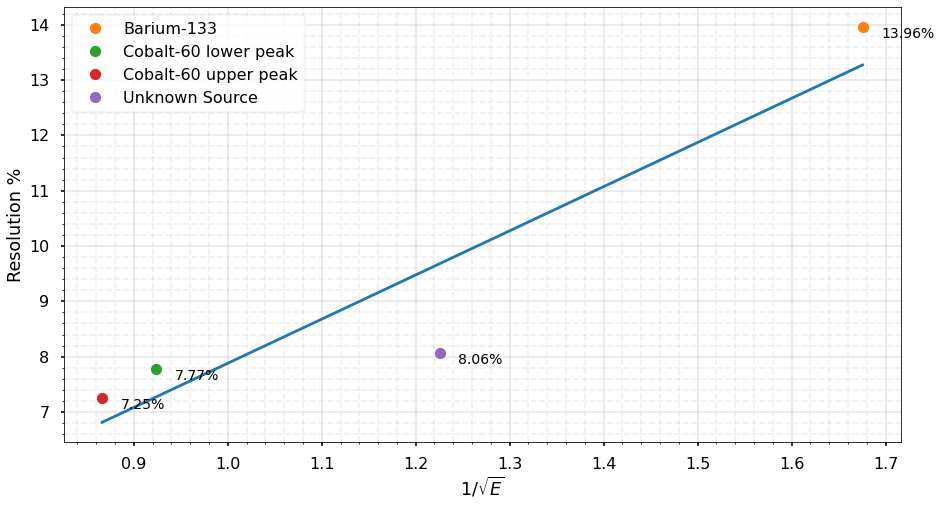

In [90]:

plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
# plt.title(f"Resolution curve")
plt.xlabel(r"$1/\sqrt{E}$")
plt.ylabel("Resolution %")
# plt.plot(np.sort(sqrt_energy[:3]), np.sort(resolution[:3]))
plt.plot(np.sort(sqe_int), np.sort(res_int))
for i in range(len(res_name)):
    plt.plot(sqrt_energy[i], resolution[i], "o", label=res_name[i])
    plt.annotate(f"{resolution[i]:.2f}%", xy=(sqrt_energy[i]+0.02,resolution[i]-0.2), fontsize=14)

plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")
plt.show()


The plot shows that it is following the resolution vs. square root of energy realtion. Only the unknown sample is outside the curve, which is probably because of some instrumental error
